## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_tensor, to_pil_image, resize

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [184]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True, transform=transforms.ToTensor())
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False, transform=transforms.ToTensor())

In [185]:

batch_size = 64 # To group each k samples together. , each iteration train with 64 photo

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

In [186]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [187]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transforms.ToTensor())
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transforms.ToTensor())

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


## Let's visualize an image and its channels

The image shape: torch.Size([1, 28, 28])
Number of channels in image:  1
The image label: 35


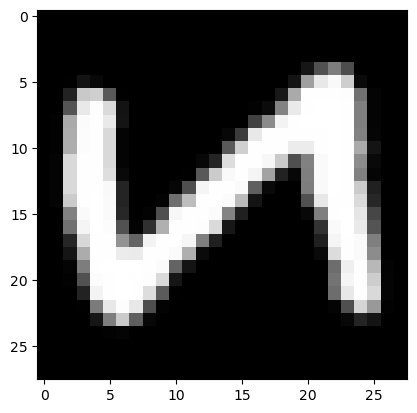

In [188]:
random_img_idx = 0 # Write any random index (between 0 and 59999)

image = train_data[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_data[random_img_idx][1]  # 1 for label part

print("The image shape:", image.shape)
print('Number of channels in image: ', image.shape[0]) # 1 channel (layer) for black-white images.
print("The image label:", label)

plt.imshow(image.reshape(28, 28), cmap='gray')

In [189]:
import torch.nn.functional as F
class MyMNISTClassifier(nn.Module): #structure if nural network
    def __init__(self, input_size):
        super(MyMNISTClassifier, self).__init__()

        
        self.linear1 = torch.nn.Linear(input_size, 542)
        self.linear2 = torch.nn.Linear(542, 180)
        self.linear3 = torch.nn.Linear(180, 113)
        self.linear4 = torch.nn.Linear(113, 62)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = self.linear4(x)

        # Apply softmax to the output
        x = F.softmax(x, dim=1)

        return x


In [190]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
input_size = 28 * 28
model = MyMNISTClassifier(input_size).to(device) #this for how use google colab

In [191]:
from torch.optim import Adam
num_epochs = 12 # This represents how many times you want to train the model over all the data (number of iterations).
lr = 1e-3 # This is the learning rate.

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr) # Adam is an optimizer (i.e. GD, SGD)
criterion = nn.CrossEntropyLoss()  # multi-class loss.

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')
print(type(criterion))

Using device cpu
<class 'torch.nn.modules.loss.CrossEntropyLoss'>


In [192]:
%%time
for epoch_no in range(num_epochs):

    model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

    epoch_weighted_loss = 0

    for batch_X,batch_y in train_loader: #enumerate(loader):

    # We need to flatten the input because it is a 2D array (image) not a linear.
        batch_X = batch_X.view(-1, 28 * 28) #to flatte each image to train each photo separately

        # Move everything to the device.
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # predicite over X.
        batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

        # Compute the loss.
        loss = criterion(batch_y_probs, batch_y)

        # Reset the gradient.
        optimizer.zero_grad()

        # Compute the gradient.
        loss.backward()

        # Update the parameters.
        optimizer.step()

        # Store the loss. We just multiplied by the number of samples in the batch to use the weighted loss.
        epoch_weighted_loss += len(batch_y) * loss.item()

    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

    train_losses.append(epoch_loss)


    # validation time

    model.eval()  # take model to evaluation mode. turn off train-only layers
    correctly_labelled = 0 # To count the accuracy.

    with torch.no_grad(): # To stop calculating the gradient since we do not need it here.

        val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.view(-1, 28 * 28)

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        # Predict on val_X
        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)

        val_epoch_weighted_loss += len(val_batch_y) * loss.item()

        # convert probailities to labels by picking the label (index) with the highest prob.
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

    val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=3.747899107275585, val_loss=3.6538028938974456. labelled 58278/116323 correctly (50.100152162513% accuracy)
Epoch: 1, train_loss=3.6460645018350433, val_loss=3.6349329184406916. labelled 60437/116323 correctly (51.95619095105869% accuracy)
Epoch: 2, train_loss=3.6205224623274352, val_loss=3.6163084050311483. labelled 62603/116323 correctly (53.81824746610731% accuracy)
Epoch: 3, train_loss=3.5951242865301083, val_loss=3.588666550330561. labelled 65816/116323 correctly (56.58038393095089% accuracy)
Epoch: 4, train_loss=3.544836436546006, val_loss=3.535023441437511. labelled 72063/116323 correctly (61.95077499720606% accuracy)
Epoch: 5, train_loss=3.5325620766790657, val_loss=3.5346042573588807. labelled 72109/116323 correctly (61.990320057082435% accuracy)
Epoch: 6, train_loss=3.527094132590092, val_loss=3.537152375549217. labelled 71805/116323 correctly (61.72897879181245% accuracy)
Epoch: 7, train_loss=3.5197564518552635, val_loss=3.5177584853890123. labelled 7408

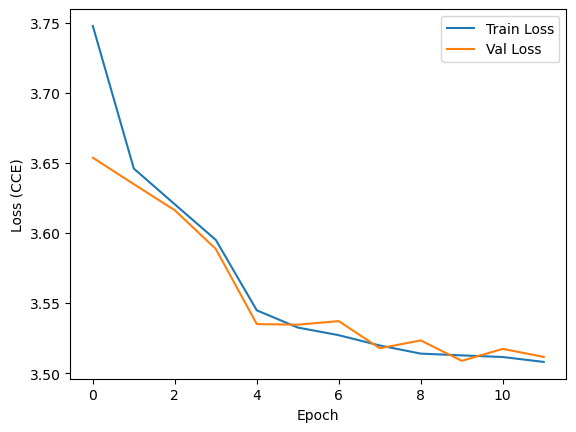

In [193]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()